## In-Class Activity: Dimensionality Reduction on the UCI Wine Dataset

Goal: see how **PCA + scaling** impacts (1) a simple classifier and (2) **2D visual separability**, then compare PCA to other popular 2D embedding methods.

Dataset: **Wine** (UCI / scikit-learn) — 178 samples, 13 continuous features, 3 classes.

Workflow:
- Load the dataset and note that features have **different units / ranges**
- Train/test split (70% / 30%)
- **Part I (PCA + Logistic Regression):** evaluate how PCA behaves with different scalers and how that affects a linear classifier
- **Part II (Other embeddings, plots only):** generate 2D plots for Kernel PCA, LDA, and UMAP (no classifier)

Part I — PCA + Logistic Regression (full 13D → 2D):
- Run **PCA(2) without scaling** → train + evaluate Logistic Regression in PCA space
- Run **Min–Max → PCA(2)** → train + evaluate Logistic Regression in PCA space
- Run **Standard → PCA(2)** → train + evaluate Logistic Regression in PCA space
- Run **Robust → PCA(2)** → train + evaluate Logistic Regression in PCA space
- For each case: report train/test performance using classification report + confusion matrix
- Also plot the 2D PCA space to visually compare separability across scalers

Part II — Other 2D embeddings (plots only, no classifier):
- **Kernel PCA (RBF)** on **standard-scaled** data → 2D scatter plot
- **LDA** on **standard-scaled** data → 2D scatter plot
- **UMAP** on **standard-scaled** data → 2D scatter plot


<details>
<summary><b>Workflow (high level)</b></summary>

1. Load the Wine dataset and inspect columns/features  
2. Train/test split (70% / 30%, stratified)  
3. Part I: fit the three Logistic Regression pipelines and compare results  
4. Visualization: recreate PCA plots (no scaling vs scaling) with decision regions  
5. Part II: fit Kernel PCA / LDA / UMAP on standardized data and plot 2D embeddings  

</details>

In [1]:
# ============================================================
# Imports + settings
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

<details>
<summary><b>Load the dataset</b></summary>

We load the Wine dataset and put it into a pandas DataFrame so it is easier to work with.

</details>

In [2]:
# ============================================================
# Load Wine (features + labels)
# ============================================================
data = load_wine(as_frame=True)
df = data.frame.copy()  # includes 'target'

print("Shape:", df.shape)
print("Feature columns:", data.feature_names)
print("Target name:", data.target_names)
df.head()

Shape: (178, 14)
Feature columns: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Target name: ['class_0' 'class_1' 'class_2']


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


<details>
<summary><b>Train/test split (70/30)</b></summary>

We do a stratified split so each class keeps roughly the same proportion in train and test.

</details>

In [3]:
# ============================================================
# Train/test split (70% / 30%), stratified
# ============================================================
X = df.drop(columns=["target"]).values
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train label counts:", np.bincount(y_train))
print("Test  label counts:", np.bincount(y_test))

Train shape: (124, 13) Test shape: (54, 13)
Train label counts: [41 50 33]
Test  label counts: [18 21 15]


<details>
<summary><b>Helper functions (evaluation + plotting)</b></summary>

- `evaluate_model(...)` prints accuracy + classification report + confusion matrix  
- `plot_decision_regions_2d(...)` draws decision regions for a 2D model  

</details>

In [4]:
# ============================================================
# Helpers
# ============================================================
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    yhat_tr = model.predict(X_tr)
    yhat_te = model.predict(X_te)

    tr_acc = accuracy_score(y_tr, yhat_tr)
    te_acc = accuracy_score(y_te, yhat_te)

    print("\n" + "=" * 78)
    print(f"{name}")
    print("-" * 78)
    print(f"Train accuracy: {tr_acc:.4f}")
    print(f"Test  accuracy: {te_acc:.4f}")

    print("\n[TEST] Classification report:")
    print(classification_report(y_te, yhat_te, digits=4, zero_division=0))
    print("[TEST] Confusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_te, yhat_te))

    return {"name": name, "train_acc": tr_acc, "test_acc": te_acc}

def plot_decision_regions_2d(ax, X2, y, clf, title, step=0.02):
    # Fit on the provided 2D data
    clf.fit(X2, y)

    x1_min, x1_max = X2[:, 0].min() - 1.0, X2[:, 0].max() + 1.0
    x2_min, x2_max = X2[:, 1].min() - 1.0, X2[:, 1].max() + 1.0
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, step),
        np.arange(x2_min, x2_max, step)
    )
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    zz = clf.predict(grid).reshape(xx1.shape)

    ax.contourf(xx1, xx2, zz, alpha=0.15)
    markers = ["^", "s", "o"]
    for c in np.unique(y):
        ax.scatter(X2[y == c, 0], X2[y == c, 1], marker=markers[int(c)], s=35, label=f"class {int(c)+1}")

    ax.set_title(title)
    ax.set_xlabel("1st component")
    ax.set_ylabel("2nd component")
    ax.legend(loc="best")

# Part I — Logistic Regression comparisons

We keep the classifier the same (Logistic Regression) and only change **scaling** and **PCA**.

Notes:
- PCA is fit on the **training set** only.
- The classifier is trained on either the original 13D space or the reduced 2D space.

In [5]:
# ============================================================
# Part I: 3 Logistic Regression pipelines
# ============================================================
lr = LogisticRegression(max_iter=5000, multi_class="auto", n_jobs=-1)

pipe_lr_unscaled = Pipeline(steps=[
    ("clf", lr),
])

pipe_pca_unscaled = Pipeline(steps=[
    ("pca", PCA(n_components=2, random_state=RANDOM_STATE)),
    ("clf", lr),
])

pipe_scaled_pca = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=RANDOM_STATE)),
    ("clf", lr),
])

results = []
results.append(evaluate_model("1) Logistic Regression (unscaled, 13D)", pipe_lr_unscaled, X_train, y_train, X_test, y_test))
results.append(evaluate_model("2) PCA(2) on unscaled data -> Logistic Regression", pipe_pca_unscaled, X_train, y_train, X_test, y_test))
results.append(evaluate_model("3) StandardScaler -> PCA(2) -> Logistic Regression", pipe_scaled_pca, X_train, y_train, X_test, y_test))

pd.DataFrame(results)[["name","train_acc","test_acc"]]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



1) Logistic Regression (unscaled, 13D)
------------------------------------------------------------------------------
Train accuracy: 0.9919
Test  accuracy: 0.9630

[TEST] Classification report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        18
           1     0.9130    1.0000    0.9545        21
           2     1.0000    0.8667    0.9286        15

    accuracy                         0.9630        54
   macro avg     0.9710    0.9556    0.9610        54
weighted avg     0.9662    0.9630    0.9625        54

[TEST] Confusion matrix (rows=true, cols=pred):
[[18  0  0]
 [ 0 21  0]
 [ 0  2 13]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



2) PCA(2) on unscaled data -> Logistic Regression
------------------------------------------------------------------------------
Train accuracy: 0.7016
Test  accuracy: 0.6852

[TEST] Classification report:
              precision    recall  f1-score   support

           0     0.9375    0.8333    0.8824        18
           1     0.6429    0.8571    0.7347        21
           2     0.4000    0.2667    0.3200        15

    accuracy                         0.6852        54
   macro avg     0.6601    0.6524    0.6457        54
weighted avg     0.6736    0.6852    0.6687        54

[TEST] Confusion matrix (rows=true, cols=pred):
[[15  0  3]
 [ 0 18  3]
 [ 1 10  4]]

3) StandardScaler -> PCA(2) -> Logistic Regression
------------------------------------------------------------------------------
Train accuracy: 0.9758
Test  accuracy: 0.9444

[TEST] Classification report:
              precision    recall  f1-score   support

           0     0.9412    0.8889    0.9143        18
          

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,name,train_acc,test_acc
0,"1) Logistic Regression (unscaled, 13D)",0.991935,0.962963
1,2) PCA(2) on unscaled data -> Logistic Regression,0.701613,0.685185
2,3) StandardScaler -> PCA(2) -> Logistic Regres...,0.975806,0.944444


# PCA visualization — 2D PCA under different scaling choices

We run PCA using the **full Wine feature vector (13 features)** and visualize the **2D PCA embedding** under four preprocessing choices:

1. **No scaling**
2. **Min–Max scaling**
3. **Standard scaling**
4. **Robust scaling**

We also overlay **logistic regression decision regions** in each 2D PCA space (for visualization only).
To avoid Colab RAM crashes, we use a **coarser grid** for decision regions.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

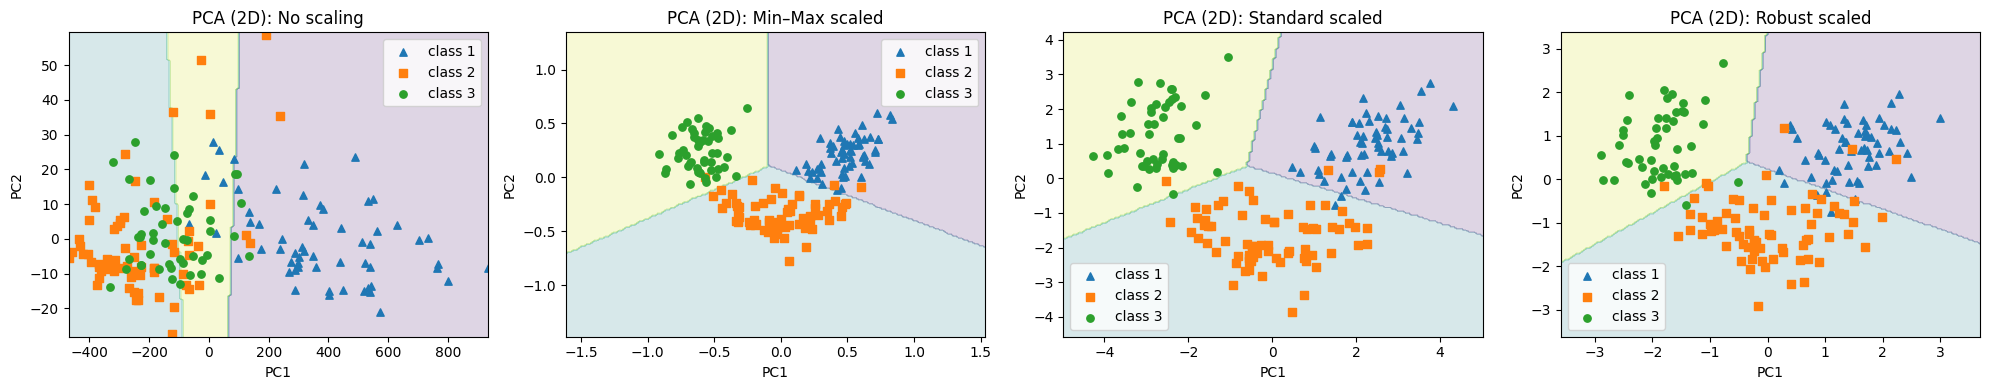

In [6]:
# ============================================================
# Memory-safe PCA visualization (13D -> 2D) under scaling choices
# ============================================================
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

def plot_decision_regions_2d_light(ax, X2, y, clf, title, grid_n=180):
    """
    Lighter version of decision-region plotting:
    - coarse grid (grid_n x grid_n)
    - float32 to reduce memory
    """
    X2 = X2.astype(np.float32, copy=False)
    y  = y.astype(np.int32, copy=False)

    # Fit classifier in the 2D space
    clf.fit(X2, y)

    # Create a coarse mesh
    pad = 0.7
    x_min, x_max = X2[:, 0].min() - pad, X2[:, 0].max() + pad
    y_min, y_max = X2[:, 1].min() - pad, X2[:, 1].max() + pad

    xx = np.linspace(x_min, x_max, grid_n, dtype=np.float32)
    yy = np.linspace(y_min, y_max, grid_n, dtype=np.float32)
    XX, YY = np.meshgrid(xx, yy)

    grid = np.column_stack([XX.ravel(), YY.ravel()]).astype(np.float32, copy=False)
    Z = clf.predict(grid).reshape(XX.shape)

    # Decision regions
    ax.contourf(XX, YY, Z, alpha=0.18)

    # Scatter points
    markers = ["^", "s", "o", "x", "D", "P"]
    for c in np.unique(y):
        ax.scatter(
            X2[y == c, 0], X2[y == c, 1],
            marker=markers[int(c) % len(markers)],
            s=28,
            label=f"class {int(c)+1}"
        )

    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend(loc="best")

# ----------------------------
# Data
# ----------------------------
X_full = X.copy()
y_full = y.copy()

# Scaling options
scalers = {
    "No scaling": None,
    "Min–Max scaled": MinMaxScaler(),
    "Standard scaled": StandardScaler(),
    "Robust scaled": RobustScaler(),
}

# Classifier (visualization only)
lr_vis = LogisticRegression(max_iter=3000, multi_class="auto", n_jobs=-1)

# Plot
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for ax, (label, scaler) in zip(axes, scalers.items()):
    # Scale (or not)
    if scaler is None:
        X_proc = X_full.astype(np.float32, copy=False)
    else:
        X_proc = scaler.fit_transform(X_full).astype(np.float32, copy=False)

    # PCA to 2D
    X_pca = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X_proc).astype(np.float32, copy=False)

    # Plot (coarse grid to avoid RAM spikes)
    plot_decision_regions_2d_light(ax, X_pca, y_full, lr_vis, f"PCA (2D): {label}", grid_n=160)

plt.tight_layout()
plt.show()


# Part II — Kernel PCA, LDA, and UMAP (plots only)

For Part II we standardize **all 13 features**, then create **2D embeddings**.

Notes:
- **Kernel PCA (RBF)** is a nonlinear extension of PCA.
- **LDA** is supervised (uses labels) and tries to maximize class separability.
- **UMAP** is a nonlinear manifold method (often good for visualization).

In [7]:
# ============================================================
# Install UMAP (Colab)
# ============================================================
!pip -q install umap-learn

In [8]:
# ============================================================
# Standardize features (fit on train, transform train/test)
# ============================================================
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(X_train)
Xte_s = scaler.transform(X_test)

def plot_embedding_2d(Z, y, title):
    plt.figure(figsize=(6, 4))
    markers = ["^", "s", "o"]
    for c in np.unique(y):
        plt.scatter(Z[y == c, 0], Z[y == c, 1], marker=markers[int(c)], s=35, label=f"class {int(c)+1}")
    plt.title(title)
    plt.xlabel("1st component")
    plt.ylabel("2nd component")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


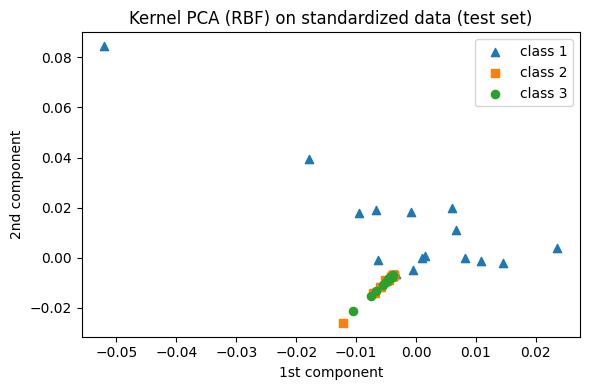

In [9]:
# 1) Kernel PCA (RBF)
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=1, fit_inverse_transform=False)
Z_kpca = kpca.fit_transform(Xtr_s)
Z_kpca_te = kpca.transform(Xte_s)
plot_embedding_2d(Z_kpca_te, y_test, "Kernel PCA (RBF) on standardized data (test set)")

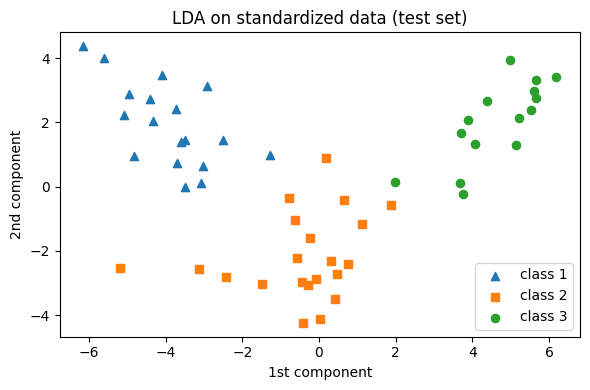

In [10]:
# 2) LDA (supervised)
lda = LDA(n_components=2)
Z_lda = lda.fit_transform(Xtr_s, y_train)
Z_lda_te = lda.transform(Xte_s)
plot_embedding_2d(Z_lda_te, y_test, "LDA on standardized data (test set)")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


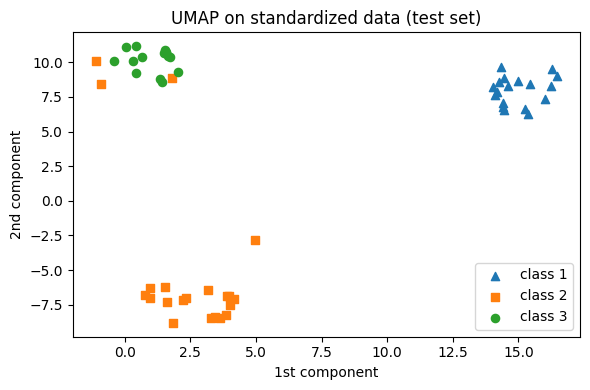

In [11]:
# 3) UMAP (nonlinear)
import umap
um = umap.UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=5, min_dist=0.1)
Z_umap = um.fit_transform(Xtr_s, y_train)
Z_umap_te = um.transform(Xte_s)
plot_embedding_2d(Z_umap_te, y_test, "UMAP on standardized data (test set)")